In this tutorial, we will model CO2 with gaussian process.

In [472]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import gpytorch as gp

# Data loading and visualization
The data is available at the following path.

In [473]:
df = pd.read_csv('/mnt/persistent-public/zhencao/co2_mm_gl.csv', comment='#', usecols=['decimal', 'average'])
df

,decimal,average
0,1980.042,338.55
1,1980.125,339.27
2,1980.208,339.60
3,1980.292,340.00
4,1980.375,340.43
...,...,...
489,2020.792,411.71
490,2020.875,413.25
491,2020.958,414.18
492,2021.042,414.95


## Plotting the data with time
We visualize the data of CO2 in time series. We can identify the data has some periodicity and the trend of going up with time.

Text(0, 0.5, 'Average CO2')

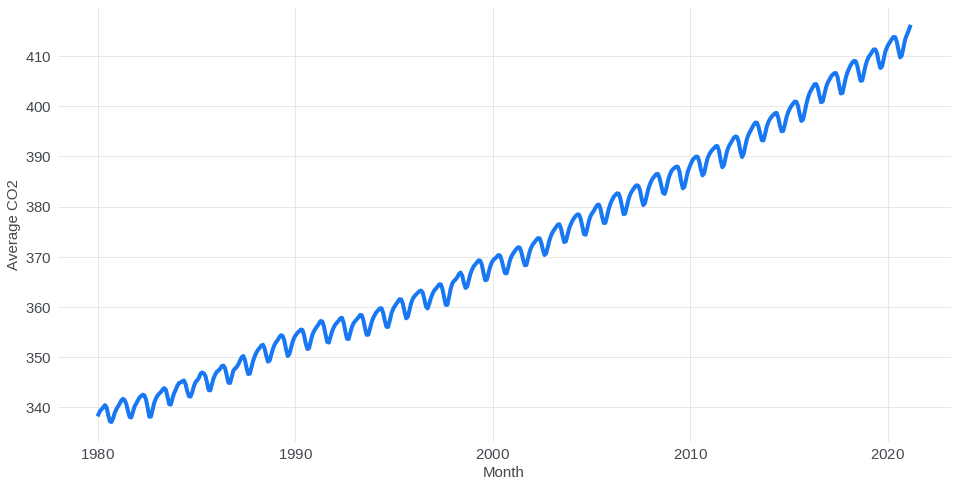

In [474]:
plt.rcParams['figure.figsize'] = 16, 8
sns.lineplot(x='decimal', y='average', data=df)
plt.xlabel('Month')
plt.ylabel('Average CO2')

## Plotting the auto-correlation
We plot the auto correlcation function below.

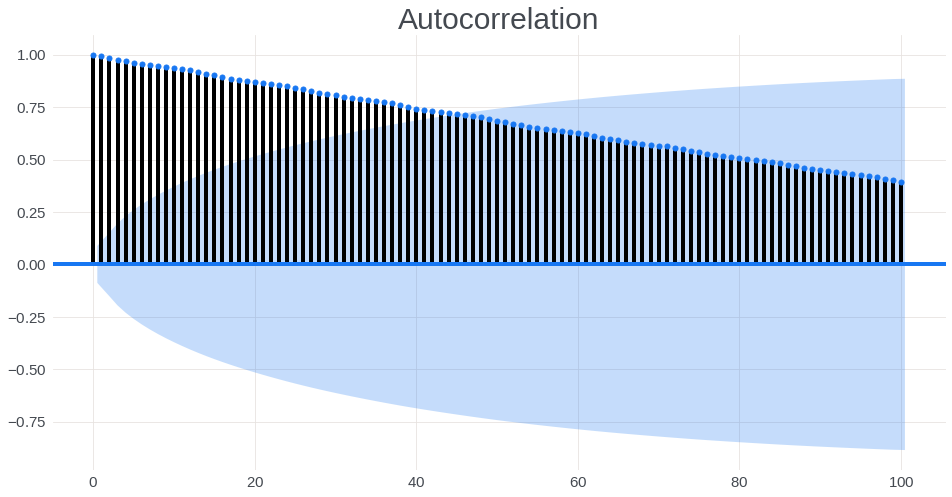

In [475]:
from statsmodels.graphics.tsaplots import plot_acf
_ = plot_acf(df['average'], lags=100)


We prepare the training set and test set data with normalizaton.

In [476]:
from sts.data import df_to_tensor

df_convert_fns = {
    'decimal': lambda x: (x - x.iloc[0])
}
df['log_average'] = np.log(df['average'])
data = df_to_tensor(df, normalize_cols=True, df_convert_fns=df_convert_fns)


In [477]:
num_trainset = 400
train_x = data[:num_trainset, ['decimal']]
train_y = data[:num_trainset, 'log_average']
test_x = data[num_trainset:, ['decimal']]
test_y = data[num_trainset:, 'log_average']
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([400, 1]) torch.Size([400]) torch.Size([94, 1]) torch.Size([94])


# Model Defining
We define the model as the addition of kernels of seasonality (periordic) and trend (RBF).

In [478]:
from sts.gp.model import TimeSeriesExactGPModel
likelihood = gp.likelihoods.GaussianLikelihood()
model = TimeSeriesExactGPModel(train_x, train_y, likelihood)
model.cov.add_seasonality(time_axis='decimal', period_length=1, fix_period=True)
model.cov.add_trend(time_axis='decimal', lengthscale=100, fix_lengthscale=True)

# Training loop
We train our model with our training set.

In [479]:
learning_rate = 0.01
num_epochs = 1000
trainer = model.train_init(torch.optim.Adam(model.trainable_params, lr=learning_rate))

In [480]:
for epoch in range(num_epochs):
    loss = trainer(train_x, train_y)
    if (epoch + 1) % 100 == 1:
        print(f'epoch {epoch+1}/{num_epochs}, loss {loss}')

epoch 1/1000, loss 0.8648936748504639


epoch 101/1000, loss 0.4206523895263672


epoch 201/1000, loss -0.08528365939855576


epoch 301/1000, loss -0.6039102673530579


epoch 401/1000, loss -1.0966287851333618


epoch 501/1000, loss -1.5163153409957886


epoch 601/1000, loss -1.79926335811615


epoch 701/1000, loss -1.9237152338027954


epoch 801/1000, loss -1.95598566532135


epoch 901/1000, loss -1.9616998434066772


# Predictions
We use our model to forecast the test set.

As we can see, the mean of our model is lower than the actual observations, while still in the credible interval.

In [481]:
from sts.data import get_mvn_stats
from torch.distributions import ComposeTransform, ExpTransform

transform = ComposeTransform([train_y.transforms['log_average'].inv, ExpTransform()])
train_mean, train_var, train_ci = get_mvn_stats(model.predict(train_x), transform)
test_mean, test_var, test_ci = get_mvn_stats(model.predict(test_x), transform)


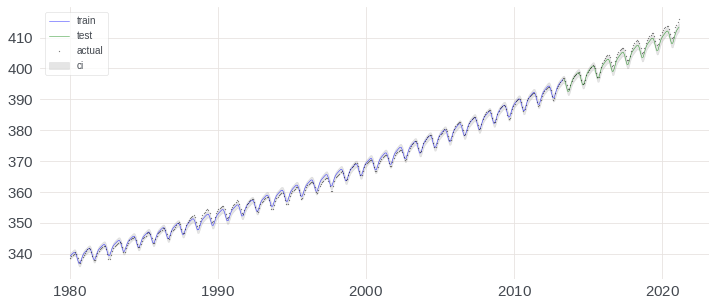

In [482]:
f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(df['decimal'][:num_trainset], train_mean, alpha=0.8, color='blue', linewidth=0.5, label='train')
ax.plot(df['decimal'][num_trainset:], test_mean, alpha=0.8, color='green', linewidth=0.5, label='test')
ax.plot(df['decimal'], df['average'], 'o', markersize=0.2, color='black', label='actual')
ax.fill_between(df['decimal'], torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]]), alpha=0.2, label='ci', color='gray')
ax.legend()

# Evaluation
Here we evaluate with MSE and MAE.

In [483]:
from sts.metrics import mape
test_y = torch.tensor(df['average'][num_trainset:].values)
mean_abs_perc_error = mape(test_y, test_mean)
MSE = torch.nn.MSELoss()
mean_squared_error = MSE(test_y, test_mean)
print(f'Mean squared error is: {mean_squared_error:.3f}')
print(f'Mean absolute error is: {mean_abs_perc_error:.3f}%')

Mean squared error is: 2.012
Mean absolute error is: 0.307%


# Kernel Decomposition
We decompose kernels to see how each kernel functions.

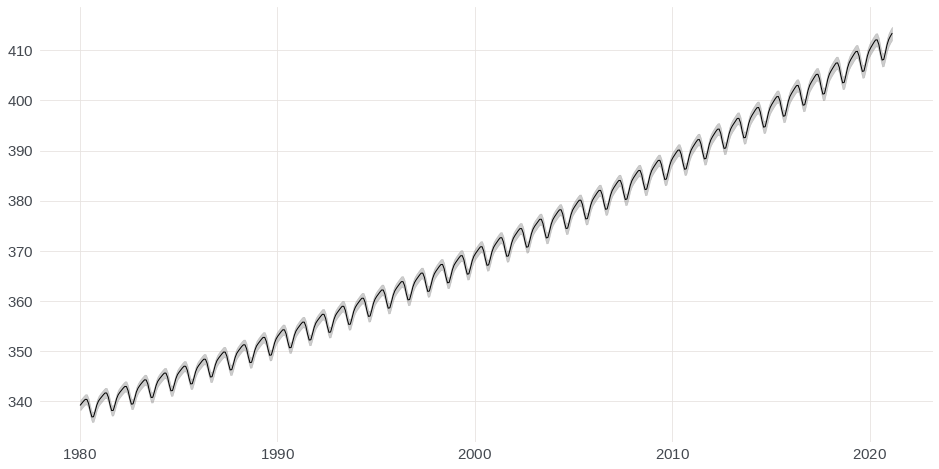

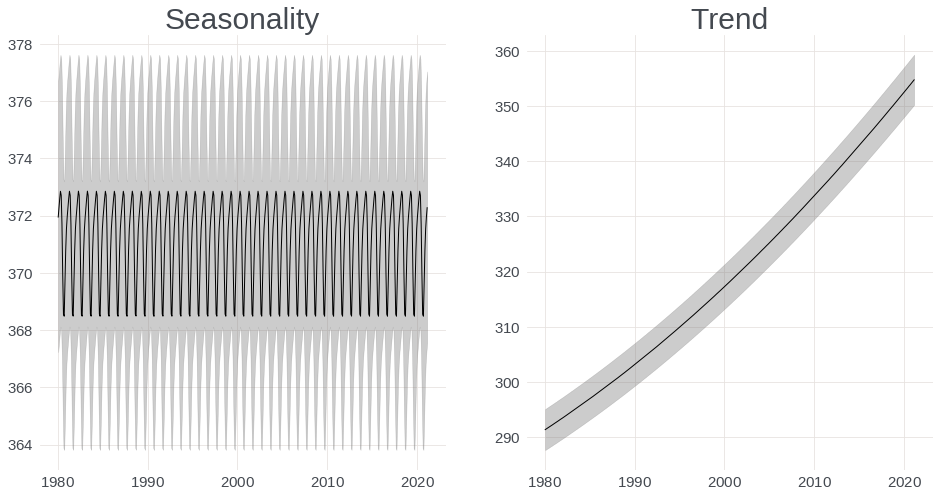

In [484]:
from sts.gp.graph import plot_components

x_all = torch.cat([train_x.tensor, test_x.tensor])
components = model.decompose_timeseries(x_all)
fig, ax = plot_components(df['decimal'], components[1], y=model.predict(x_all), transform=transform)


# Further improvement
As we show above, the major trend is captured by RBF kernel but deviates a little at the forecasting part. We would like to make better prediction with more proper kernels. Now we try polynomial kernel with power 2 to capture the trend, and repeat every step above. 

## Model Defining: polynomial kernel for trend

This model has a periodic kernel to capture the seasonality and a polynomial kernel of power 2 to capture the long term trend.

In [485]:
from sts.gp.model import TimeSeriesExactGPModel
likelihood = gp.likelihoods.GaussianLikelihood()
model = TimeSeriesExactGPModel(train_x, train_y, likelihood)
model.cov.add_seasonality(time_axis='decimal', period_length=1, fix_period=True)
model.cov.add_trend(time_axis='decimal', kernel_cls=gp.kernels.PolynomialKernel, power=2, name='LongTrend')


## Traning loop

In [486]:
trainer = model.train_init(torch.optim.Adam(model.trainable_params, lr=learning_rate))
for epoch in range(num_epochs):
    loss = trainer(train_x, train_y)
    if (epoch + 1) % 100 == 1:
        print(f'epoch {epoch+1}/{num_epochs}, loss {loss}')

epoch 1/1000, loss 0.7857952117919922


epoch 101/1000, loss 0.37224793434143066


epoch 201/1000, loss -0.11693023890256882


epoch 301/1000, loss -0.6290424466133118


epoch 401/1000, loss -1.1186810731887817


epoch 501/1000, loss -1.5382708311080933


epoch 601/1000, loss -1.8263381719589233


epoch 701/1000, loss -1.955971121788025


epoch 801/1000, loss -1.9883410930633545


epoch 901/1000, loss -1.9929193258285522


## Predictions
As we can see from the figure below, our model does better in the forecasting part.

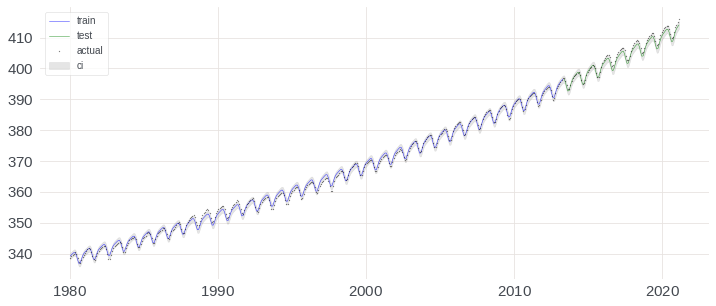

In [487]:
train_mean, train_var, train_ci = get_mvn_stats(model.predict(train_x), transform)
test_mean, test_var, test_ci = get_mvn_stats(model.predict(test_x), transform)

f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(df['decimal'][:num_trainset], train_mean, alpha=0.8, color='blue', linewidth=0.5, label='train')
ax.plot(df['decimal'][num_trainset:], test_mean, alpha=0.8, color='green', linewidth=0.5, label='test')
ax.plot(df['decimal'], df['average'], 'o', markersize=0.2, color='black', label='actual')
ax.fill_between(df['decimal'], torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]]), alpha=0.2, label='ci', color='gray')
ax.legend()

## Decompose kernels

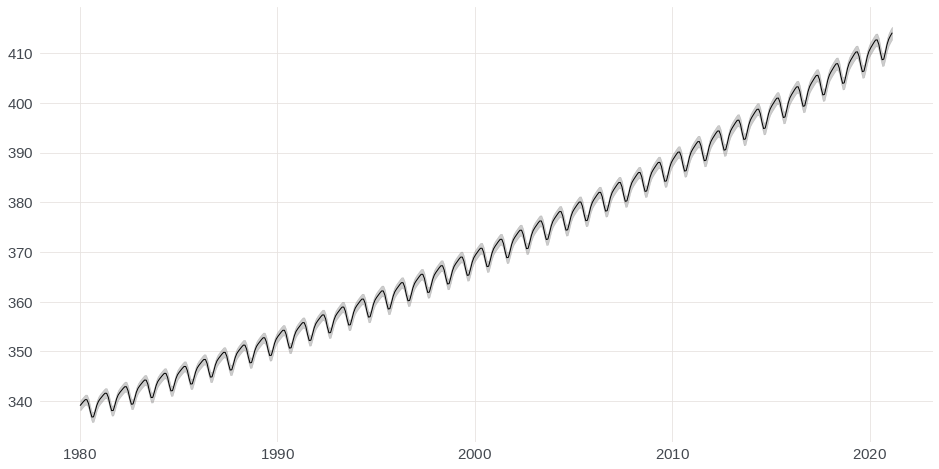

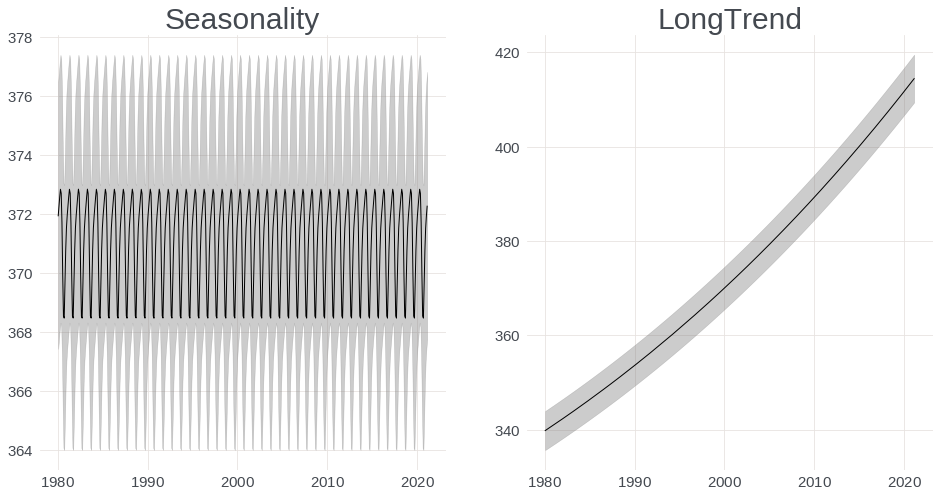

In [488]:
components = model.decompose_timeseries(x_all)
fig, ax = plot_components(df['decimal'], components[1], y=model.predict(x_all), transform=transform)

## Evaluation
The MSE and MAE show that the model with polynomial kernel for trend performs better than RBF.

In [489]:
from sts.metrics import mape
test_y = torch.tensor(df['average'][num_trainset:].values)
mean_abs_perc_error = mape(test_y, test_mean)
MSE = torch.nn.MSELoss()
mean_squared_error = MSE(test_y, test_mean)
print(f'Mean squared error is: {mean_squared_error:.3f}')
print(f'Mean absolute error is: {mean_abs_perc_error:.3f}%')

Mean squared error is: 1.089
Mean absolute error is: 0.221%
